<a href="https://colab.research.google.com/github/martinpius/AUTOENCODERS/blob/main/De_noising_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import torch
  print(f">>>> You are on CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)} {e}\n>>>> please correct {type(e)} and reload your drive")
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
def time_fmt(t: float = 128.91)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h} min: {m:>02} sec: {s:>05.2f}"
print(f">>>> testing the time formating function.........\n>>>> time elapsed\t{time_fmt()}")

Mounted at /content/drive/
>>>> You are on CoLaB with torch version: 1.9.0+cu102
>>>> testing the time formating function.........
>>>> time elapsed	hrs: 0 min: 02 sec: 08.00


In [3]:
# In this notebook we are going to train a simple Autoencoder 
# with aid of Fully connected neural network  to recover the 
# original data from the noisy data
# For demonstration, we will use MNIST_Fashion dataset.

In [46]:
import torch
from torch import optim, nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tensorflow import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datetime, time, random
%load_ext tensorboard


In [5]:
# Set the random-seeds for reproducibility and the gpu device to deterministic
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
# Hyperparameters of the network and model's specification hyper parameters
batch_size = 64
learning_rate = 1e-3
EPOCHS = 1000
enc_input_dim = 784
enc_hidden1_dim = 512
enc_hidden2_dim = 128
enc_out_dim = 64
dec_input_dim = 64
dec_hidden1_dim = 128
dec_hidden2_dim = 512
dec_out_dim = 784



In [7]:
# Building the network: Our model consists of two part. The encoder's network
# which takes the noisy images and gives the hidden representantion. The decoder's
# network that reconstruct the original image from the hidden representantion.


In [8]:
# The encoder's network: This is a simple FC network with sigmoid activation function
# Any other activation also may be tried such as ReLU and Tanh
class Encoder(nn.Module):
  def __init__(self, enc_input_dim, enc_hidden1_dim, enc_hidden2_dim, enc_out_dim):
    super(Encoder, self).__init__()
    self.layer1 = nn.Linear(enc_input_dim, enc_hidden1_dim)
    self.layer2 = nn.Linear(enc_hidden1_dim, enc_hidden2_dim)
    self.enc_out = nn.Linear(enc_hidden2_dim, enc_out_dim)
    self.act1 = nn.Sigmoid()
  
  def forward(self, input_tensor):
    """
    input_tensor: shape == [batch_size, enc_input_dim]
    enc_out: shape == [batch_size, enc_out_dim]
    """
    x = self.act1(self.layer1(input_tensor))
    x = self.act1(self.layer2(x))
    return self.act1(self.enc_out(x))

In [9]:
# Instantiating the encoder class and assessing the desired output shape:
encoder = Encoder(enc_input_dim, enc_hidden1_dim, enc_hidden2_dim, enc_out_dim).to(device = device)
input_tensor = torch.randn(size = (batch_size, enc_input_dim)).to(device = device)
assert encoder(input_tensor).shape == (batch_size, enc_out_dim)

In [10]:
# The decoder's network: This consists of a simple FC-layers with sigmoid activation
class Decoder(nn.Module):
  def __init__(self, dec_input_dim, dec_hidden1_dim, dec_hidden2_dim, dec_out_dim):
    super(Decoder, self).__init__()
    self.layer1 = nn.Linear(dec_input_dim, dec_hidden1_dim)
    self.layer2 = nn.Linear(dec_hidden1_dim, dec_hidden2_dim)
    self.dec_out = nn.Linear(dec_hidden2_dim, dec_out_dim)
    self.act2 = nn.Sigmoid()
  
  def forward(self, input_tensor):
    """
    input_tensor: shape == enc_out.shape == [batch_size, enc_out_dim]
    dec_out: shape == [batch_size, dec_out_dim == enc_input_dim]
    """
    x = self.act2(self.layer1(input_tensor))
    x = self.act2(self.layer2(x))
    return self.dec_out(x)
    

In [11]:
# Instatiating the decoder's network and check for the desired output shape:
decoder = Decoder(dec_input_dim, dec_hidden1_dim, dec_hidden2_dim, dec_out_dim).to(device = device)
assert decoder(encoder(input_tensor)).shape == (batch_size, dec_out_dim)

In [21]:
# We finaly join the encoder and the decoder networks to form our model class
class Model(nn.Module):
  def __init__(self, encoder, decoder):
    super(Model, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
  
  def forward(self, input_tensor):
    """
    input_tensor == shape: [batch_size, enc_input_dim]
    output == shape: [batch_size, input_dim]
    """
    enc_out = self.encoder(input_tensor) # shape == [batch_size, enc_out_dim]
    output = self.decoder(enc_out) # shape == [batch_size, enc_input_dim == dec_output_dim]
    return output

In [25]:
# Instantiating and testing the model class to see the desired output shape:
model = Model(encoder, decoder).to(device = device)
assert model(input_tensor).shape == (batch_size, enc_input_dim)

In [27]:
# Initialize the network learnable weights to random normal (0, 0.02) a biases to 0
def __initializer__(model):
  for name, par in model.named_parameters():
    if "weight" in name: # initializes the slopes to N(0.00, 0.02)
      nn.init.normal_(par.data, mean = 0.00, std = 0.02)
    else: # initialize the biases to 0
      nn.init.constant_(par.data, 0)

In [28]:
model.apply(__initializer__)

Model(
  (encoder): Encoder(
    (layer1): Linear(in_features=784, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=128, bias=True)
    (enc_out): Linear(in_features=128, out_features=64, bias=True)
    (act1): Sigmoid()
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=64, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=512, bias=True)
    (dec_out): Linear(in_features=512, out_features=784, bias=True)
    (act2): Sigmoid()
  )
)

In [29]:
# Count the number of trainable parameters available in the network:
def __counter__(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f">>>> total number of trainable weights in the network is: {__counter__(model):,} parameters")

>>>> total number of trainable weights in the network is: 952,400 parameters


In [31]:
# Importing and preprocessing the data from torchvission:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean = 0.1, std = 1)
])


In [32]:
train_data = datasets.FashionMNIST(root = "train/mnst_autoencoder", train = True, transform = transform, download = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting train/mnst_autoencoder/FashionMNIST/raw/train-images-idx3-ubyte.gz to train/mnst_autoencoder/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting train/mnst_autoencoder/FashionMNIST/raw/train-labels-idx1-ubyte.gz to train/mnst_autoencoder/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting train/mnst_autoencoder/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to train/mnst_autoencoder/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting train/mnst_autoencoder/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to train/mnst_autoencoder/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [34]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
x_batch_train, y_batch_train = next(iter(train_loader))
print(f">>>> x_train_batch_shape: {x_batch_train.shape}, y_train_batch_shape: {y_batch_train.shape}")

>>>> x_train_batch_shape: torch.Size([64, 1, 28, 28]), y_train_batch_shape: torch.Size([64])


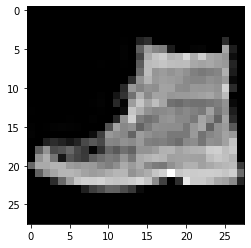

In [37]:
# Ploting the original data: (Before adding the noise)
plt.imshow(x_batch_train[0].reshape(28, 28), cmap = "gray")

In [38]:
# Adding the noise to the training data (we shift the image location by some constant and adding normal noise)
x_batch_noise = x_batch_train + 10 * torch.randn(size = x_batch_train.shape)

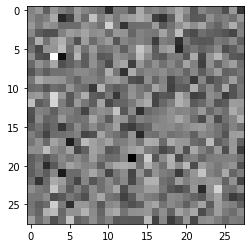

In [39]:
# Plotting the noisy image
plt.imshow(x_batch_noise[0].reshape(28, 28), cmap = "gray")

In [40]:
# Preparing the tensorboard environment to desplay summary loss 
current_time = datetime.datetime.now().timestamp()
train_path = "logs/tensorboard/train_mnist/autoencoder/" + str(current_time)
train_writer = summary.create_file_writer(logdir = train_path)


In [41]:
# Get the optimizer
optimizer = optim.RMSprop(params = model.parameters())

In [65]:
# The training loop from scratch:
def auto_encoder_train_loop(model, iterator, optimizer):
  model.train()
  step = 0
  loss_per_epoch = 0
  for batch, (data, _) in enumerate(iterator):
    data = data.to(device = device)
    data = data.view(-1, 784)
    data_noisy = data + 10 * torch.randn(size = data.shape)
    #data_noisy = data_noisy.view(-1, 784)
    optimizer.zero_grad()
    output = model(data_noisy).view(-1) # shape == [batc_size * output_dim]
    train_loss = torch.mean((output - data.view(-1))**2) # The MSE btn the pixels for the real and noisy imgs
    train_loss.backward()
    optimizer.step()
    loss_per_epoch += train_loss
    if batch % 100 == 0:
      with train_writer.as_default():
        summary.scalar("train_loss", train_loss.detach().numpy(), step = step)
        step += 1
  return loss_per_epoch / len(iterator)


In [ ]:
# Running the train loop
tic = time.time()
for epoch in range(EPOCHS):
  print(f"\n>>>> training starts for epoch {epoch + 1}.......................\n>>>> please wait ......................................")
  mean_loss = auto_encoder_train_loop(model, train_loader, optimizer)
  print(f"\n>>>> end of epoch {epoch + 1}, average train loss is: {mean_loss:.4f}")
toc = time.time()
print(f">>>> total elapsed time for training the simple autoencoder's net for {EPOCHS} epochs is: {time_fmt(toc - tic)}")

%tensorboard --logdir logs/tensorboard



>>>> training starts for epoch 1.......................
>>>> please wait ......................................

>>>> end of epoch 1, average train loss is: 0.0877

>>>> training starts for epoch 2.......................
>>>> please wait ......................................

>>>> end of epoch 2, average train loss is: 0.0876

>>>> training starts for epoch 3.......................
>>>> please wait ......................................

>>>> end of epoch 3, average train loss is: 0.0876

>>>> training starts for epoch 4.......................
>>>> please wait ......................................

>>>> end of epoch 4, average train loss is: 0.0877

>>>> training starts for epoch 5.......................
>>>> please wait ......................................
